In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths

In [2]:
dataset = ".\dataset"

# Learning rate
lr = 0.0001
epochs = 25
batch_size = 8

In [3]:
images = list(paths.list_images(dataset))
data = []
labels = []
for imagePath in images:
    label = imagePath.split(os.path.sep)[2]
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    
    data.append(image)
    labels.append(label)
    
# Converting data and labels lists to numpy arrays
# Scaling the pixel intensities to [0,1] of the images
data = np.array(data) / 255.0
labels = np.array(labels)

In [4]:
# One-hot encoding of the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [5]:
# Splitting the data into training and testing with 80% of data for the former
train_X, test_X, train_Y, test_Y = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [6]:
# Data Augmentation for better generalization
train_aug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [7]:
# Loading the VGG16 model excluding its FC layer head
vggmodel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

In [8]:
# Constructing a head of the model to place it on top of the model
head = vggmodel.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name="flatten")(head)
head = Dense(64, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(2, activation="softmax")(head)

# Adding our constructed head to the vgg model
model = Model(inputs=vggmodel.input, outputs=head)

# Freeze all the layers in vgg model other than head
for layer in vggmodel.layers:
    layer.trainable = False

In [9]:
# Training our whole model (where except head all other layers are frozen)
# compiling the model
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr/epochs), metrics=["accuracy"])

history = model.fit_generator(
            train_aug.flow(train_X, train_Y, batch_size = batch_size),
            steps_per_epoch = len(train_X)//batch_size,
            validation_data = (test_X, test_Y),
            validation_steps = len(test_X)//batch_size,
            epochs = epochs)

C:\Users\nvkanirudh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-9-fcbd986c7fdc>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
5/5 [==============================] - 49s 8s/step - loss: 0.8023 - accuracy: 0.4750 - val_loss: 0.7070 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 4s 800ms/step - loss: 0.7830 - accuracy: 0.4750 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 4s 797ms/step - loss: 0.7146 - accuracy: 0.5250 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 4s 805ms/step - loss: 0.7388 - accuracy: 0.5500 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 5/25
5/5 [==============================] - 4s 797ms/step - loss: 0.7037 - accuracy: 0.6000 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 6/25
5/5 [==============================] - 4s 796ms/step - loss: 0.6632 - accuracy: 0.6500 - val_loss: 0.6837 - val_accuracy: 0.5000
Epoch 7/25
5/5 [==============================] - 4s 802ms/step - loss: 0.6769 - accuracy: 0.5750 - val_loss: 0.6811 - val_accuracy: 0.6000
Epoch 8/25
5/5 [======

In [10]:
# Predicting the test images
pred = model.predict(test_X, batch_size=batch_size)

# Checking which label has the highest predicted probability 
pred = np.argmax(pred, axis=1)

print(classification_report(test_Y.argmax(axis=1), pred, target_names = lb.classes_))

              precision    recall  f1-score   support

       covid       0.67      0.80      0.73         5
      normal       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



In [11]:
# Confusion Matrix, Accuracy, Sensitivity, and Specificity
cm = confusion_matrix(test_Y.argmax(axis=1), pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[4 1]
 [2 3]]
acc: 0.7000
sensitivity: 0.8000
specificity: 0.6000


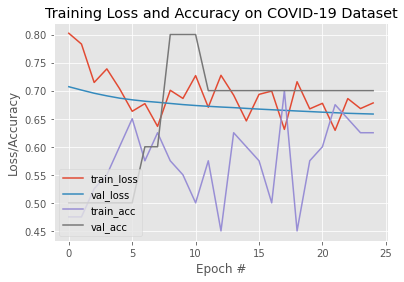

In [12]:
# Plotting training and validation loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("evaluation_plot.jpeg")

In [13]:
model.save("covid-19", save_format="h5")